In [83]:
from typing import List, Dict, Any, Tuple, Generator
import json
import os
import dataclasses as dc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from connections import Connection, ConnectionDay


In [2]:
connections_file = 'connections-2024-05-23.json'
with open(connections_file, 'r') as f:
    data = json.load(f)

connections_days = [ConnectionDay(**d) for d in data]
for c in connections_days:
    c.connections = [Connection(**d) for d in c.connections]
print(len(connections_days))

348


In [91]:
def get_words(cd: ConnectionDay):
    # Get a list of all words in the day's connections
    return [word for c in cd.connections for word in c.words]

def emoji_to_str(emoji: str) -> str:
    # Convert an emoji to a number
    if emoji == "🟡":
        return "(1)"
    elif emoji == "🟢":
        return "(2)"
    elif emoji == "🔵":
        return "(3)"
    elif emoji == "🟣":
        return "(4)"
    return "emoji"

def get_word_to_level(cd: ConnectionDay) -> Dict[str, str]:
    word2level = {}
    for connection in sample_day.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = level
    return word2level

def is_idxes_match(idxes:List[int]) -> str:
    """List of indexes to a label or (x)"""
    idx_set = set(idxes)
    if idx_set == set(range(4)):
        return "(1)"
    if idx_set == set(range(4,8)):
        return "(2)"
    if idx_set == set(range(8,12)):
        return "(3)"
    if idx_set == set(range(12,16)):
        return "(4)"
    return "(x)"

sample_day = connections_days[0]
sample_words = get_words(sample_day)
print(f"Got {len(sample_words)}: {sample_words}")
print(sample_day)
word2level = get_word_to_level(sample_day)

Got 16: ['DUCT', 'DRAIN', 'PIPE', 'SEWER', 'CHEESE', 'CORN', 'SAP', 'SCHMALTZ', 'EGG', 'KNUCKLES', 'SMILE', 'WINDOW', 'CHUMP', 'CLIMATE', 'LOOSE', 'SEA']
ConnectionDay(date='May 24, 2024', iteration=348, connections=[Connection(level='🟡', connection='CONDUITS FOR WATER REMOVAL', words=['DUCT', 'DRAIN', 'PIPE', 'SEWER']), Connection(level='🟢', connection='FOOD PRODUCTS ASSOCIATED WITH SENTIMENTALITY', words=['CHEESE', 'CORN', 'SAP', 'SCHMALTZ']), Connection(level='🔵', connection='THINGS TO CRACK', words=['EGG', 'KNUCKLES', 'SMILE', 'WINDOW']), Connection(level='🟣', connection='___ CHANGE', words=['CHUMP', 'CLIMATE', 'LOOSE', 'SEA'])])


In [4]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Mean pooling: Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model and tokenizer
model_name = "sentence-transformers/bert-base-nli-mean-tokens"
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embeddings(words):
    # Tokenize words
    encoded_input = tokenizer(words, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, mean pooling
    unnormalized = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    return F.normalize(unnormalized, p=2, dim=1)

get_embeddings(sample_words)

tensor([[-0.0092,  0.0207,  0.0263,  ...,  0.0923,  0.0588, -0.0011],
        [-0.0343,  0.0681,  0.0416,  ...,  0.0122,  0.0981, -0.0634],
        [ 0.0002,  0.0598,  0.0124,  ...,  0.0812,  0.0551, -0.0148],
        ...,
        [-0.0101,  0.0802,  0.0762,  ..., -0.0201, -0.0826,  0.0287],
        [-0.0252,  0.0533,  0.0055,  ...,  0.0047,  0.0248, -0.0560],
        [-0.0173,  0.0730, -0.0056,  ..., -0.0043, -0.0114,  0.1390]])

In [5]:
embeddings = get_embeddings(sample_words)
print(f"Got embeddings: {embeddings.shape}")

Got embeddings: torch.Size([16, 384])


In [33]:
m2 = SentenceTransformer(model_name)
print(m2.encode('hello').shape)
emb_dims = m2.encode('hello').shape[0]

(384,)


In [ ]:
# Run everything above here to get the environment setup.

# End Setup

In [9]:
import sklearn.cluster

def visualize_score(cd: ConnectionDay, words:List[str], labeling):
    word2level = {}
    for connection in cd.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = level

    grouping = {}
    for word, label in zip(words, labeling):
        if label not in grouping:
            grouping[label] = []
        grouping[label].append(f"{word}{word2level[word]}")

    return grouping


km_cluster = sklearn.cluster.KMeans(n_clusters=4)

clustering = km_cluster.fit_predict(embeddings)
visualize_score(connections[0], sample_words, clustering)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/michael/.pyenv/versions/3.11/envs/ml/lib/python3.11/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


NameError: name 'connections' is not defined

In [ ]:
for i in range(10):
    embeddings = get_embeddings(get_words(connections_days[i]))
    clustering = km_cluster.fit_predict(embeddings)
    print(visualize_score(connections_days[i], get_words(connections_days[i]), clustering))

{3: ['BIT🟡', 'DASH🟡', 'PINCH🟡', 'TOUCH🟡', 'DEAL🟢', 'CUE🔵', 'FACE🟣'], 1: ['BUY🟢', 'STEAL🟢', 'VALUE🟢', 'RACK🔵', 'MAC🟣', 'POCKET🟣'], 0: ['BALL🔵', 'MATCH🟣'], 2: ['CHALK🔵']}
{0: ['CHARM🟡', 'MAGIC🟡'], 1: ['HEX🟡', 'SPELL🟡', 'BAY🟣', 'SCOTT🟣', 'WOO🟣'], 3: ['INSTRUMENT🟢', 'TOOL🟢', 'CARPENTER🟣'], 2: ['PAWN🟢', 'PUPPET🟢', 'CAPE🔵', 'MASK🔵', 'TIGHTS🔵', 'UNDERWEAR🔵']}
{1: ['FLUSH🟡', 'CHOP🟢', 'DICE🟢', 'MINCE🟢', 'BURY🟣', 'LEACHY🟣'], 2: ['LOADED🟡', 'SQUARE🔵', 'STRAIGHT🔵', 'STUFFY🔵', 'TRADITIONAL🔵', 'CURRENT🟣', 'PAIR🟣'], 3: ['RICH🟡', 'WEALTHY🟡'], 0: ['CUBE🟢']}
{2: ['BULLDOG🟡', 'DOGLEG🟢', 'SWITCHBACK🟢', 'ZAG🟢', 'CATEGORIES🔵', 'CHARADES🔵', 'WEREWOLF🔵', 'MOUSETRAP🟣'], 3: ['CATFISH🟡', 'FISHBOWL🔵'], 1: ['HORSEFLY🟡', 'TURTLEDOVE🟡'], 0: ['HAIRPIN🟢', 'CLOCK🟣', 'MATTRESS🟣', 'TRAMPOLINE🟣']}
{0: ['BASE🟡', 'CONTACT🟢', 'MESSAGE🟢', 'PING🟢', 'TEXT🟢', 'FRUIT🔵', 'SKULL🔵', 'CAN🟣', 'GARDEN🟣'], 1: ['DIRTY🟡', 'LOW🟡', 'VILE🟡'], 2: ['PITCHER🔵', 'BATTER🟣'], 3: ['TABLECLOTH🔵', 'PONG🟣']}
{0: ['PIC🟡', 'SHOT🟡', 'SNAP🟡', 'CINCH🟢', 'T

In [47]:
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import AgglomerativeClustering

def plot_denogram(cd, words, embeddings):
    word2level = {}
    for connection in cd.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = level
    wordlabels = [f"{word}{emoji_to_str(word2level[word])}" for word in words]
    Z = linkage(embeddings, 'ward')
    dendrogram(Z, labels=wordlabels, orientation='left')
    plt.show()

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(embeddings)

plt.title('Hierarchical Clustering Dendrogram')
plot_denogram(sample_day, sample_words, embeddings)
print(sample_day)

NameError: name 'embeddings' is not defined

In [ ]:
"""How often are the closest words in the embedding also in the same connection?"""
"""If it is common, then we could use that to build a context for the first words."""
from sklearn.metrics.pairwise import cosine_similarity

def get_closest_words(cd: ConnectionDay, words: List[str], embeddings):
    word2level = {}
    for connection in cd.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = f"{word}{level}"

    word2idx = {word: i for i, word in enumerate(words)}
    closest_words = []
    for i, word in enumerate(words):
        distances = cosine_similarity(embeddings[i].reshape(1, -1), embeddings).flatten()
        closest_idx = distances.argsort()[::-1]

        closest_words.append([word2level[words[j]] for j in closest_idx[:2]])
    return closest_words

print(get_closest_words(sample_day, sample_words, embeddings))


[['BIT🟡', 'CUE🔵'], ['DASH🟡', 'CUE🔵'], ['PINCH🟡', 'DASH🟡'], ['TOUCH🟡', 'CHALK🔵'], ['BUY🟢', 'CHALK🔵'], ['DEAL🟢', 'POCKET🟣'], ['STEAL🟢', 'CUE🔵'], ['VALUE🟢', 'CHALK🔵'], ['BALL🔵', 'CHALK🔵'], ['CHALK🔵', 'VALUE🟢'], ['CUE🔵', 'POCKET🟣'], ['RACK🔵', 'CHALK🔵'], ['FACE🟣', 'CHALK🔵'], ['MAC🟣', 'BALL🔵'], ['MATCH🟣', 'POCKET🟣'], ['POCKET🟣', 'CUE🔵']]


In [ ]:
def get_closest_words(cd: ConnectionDay, n:int=10):
    """
    In a given day, produce a list of the top 10 closest word pairs.
    Return a list of (distance, w1, w2, shared_level/None)
    """
    words = get_words(cd)
    embeddings = get_embeddings(words)
    word2level = {}
    for connection in cd.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = level

    word2idx = {word: i for i, word in enumerate(words)}
    closest_words = []

    for i, word in enumerate(words):
        distances = cosine_similarity(embeddings[i].reshape(1, -1), embeddings).flatten()
        closest_idx = distances.argsort()[::-1][1]
        closest_distance = distances[closest_idx]

        closest_word = words[closest_idx]
        shared_level = None
        if word2level[word] == word2level[closest_word]:
            shared_level = word2level[word]

        closest_words.append((closest_distance, word, closest_word, shared_level))

    closest_words.sort(key=lambda x: -1 * x[0])
    return closest_words[:n]

print(get_closest_words(sample_day))

all_closest = []
for cd in connections_days:
    all_closest.extend(get_closest_words(cd,1))

[(0.6163875, 'BUY', 'DEAL', '🟢'), (0.6163875, 'DEAL', 'BUY', '🟢'), (0.5370927, 'STEAL', 'BUY', '🟢'), (0.4942256, 'PINCH', 'TOUCH', '🟡'), (0.4942256, 'TOUCH', 'PINCH', '🟡'), (0.4581131, 'BALL', 'MATCH', None), (0.4581131, 'MATCH', 'BALL', None), (0.45069528, 'CUE', 'BALL', '🔵'), (0.4441938, 'POCKET', 'PINCH', None), (0.4316692, 'FACE', 'MATCH', '🟣')]


<Axes: xlabel='level', ylabel='count'>

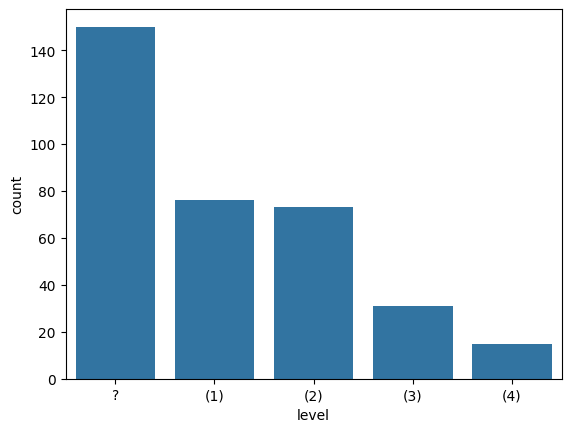

In [ ]:
closest = pd.DataFrame(all_closest, columns=['distance', 'w1', 'w2', 'level'])

# map the function emoji_to_str over the column level
closest['level'] = closest['level'].map(emoji_to_str)
closest

# sns.catplot(closest, x='level', y='distance')
sns.countplot(closest, x='level', order=['?', '(1)', '(2)', '(3)', '(4)'])

**idea**: put the top two words together and get that embedding. Use the sentence transformer. Now compare the rest of the words in the day to that new vector.

In [ ]:

for sample_day in connections_days[:10]:
    words = get_words(sample_day)
    embeddings = get_embeddings(words)
    word2level = {}
    for connection in sample_day.connections:
        level = connection.level
        for word in connection.words:
            word2level[word] = level

    word2idx = {word: i for i, word in enumerate(words)}
    closest_words = []

    for i, word in enumerate(words):
        distances = cosine_similarity(embeddings[i].reshape(1, -1), embeddings).flatten()
        closest_idx = distances.argsort()[::-1][1]
        closest_distance = distances[closest_idx]

        closest_word = words[closest_idx]
        shared_level = None
        if word2level[word] == word2level[closest_word]:
            shared_level = word2level[word]

        closest_words.append((closest_distance, word, closest_word, shared_level))

    closest_words.sort(key=lambda x: -1 * x[0])
    (d1, w1, w2, isMatch) = closest_words[0]

    print(f"Closest words: {w1} and {w2} with distance {d1} and match {isMatch}")
    new_embedding = (embeddings[word2idx[w1]] + embeddings[word2idx[w2]]) / 2

    masked_embeddings = embeddings.clone()
    masked_embeddings[word2idx[w1]] = torch.zeros(masked_embeddings.shape[1])
    masked_embeddings[word2idx[w2]] = torch.zeros(masked_embeddings.shape[1])
    # print(masked_embeddings[word2idx[w1]])
    distances = cosine_similarity(new_embedding.reshape(1, -1), masked_embeddings).flatten()
    closest_idx = distances.argsort()[::-1]
    closest_words = [f"{words[i]}{word2level[words[i]]}" for i in closest_idx[:5]]
    print(f"{closest_words}")



Closest words: BUY and DEAL with distance 0.6163874864578247 and match 🟢
['STEAL🟢', 'VALUE🟢', 'MATCH🟣', 'BIT🟡', 'POCKET🟣']
Closest words: MAGIC and SPELL with distance 0.5950139760971069 and match 🟡
['CHARM🟡', 'PAWN🟢', 'PUPPET🟢', 'TOOL🟢', 'HEX🟡']
Closest words: RICH and WEALTHY with distance 0.901329755783081 and match 🟡
['CHOP🟢', 'FLUSH🟡', 'CUBE🟢', 'SQUARE🔵', 'LEACHY🟣']
Closest words: CATFISH and FISHBOWL with distance 0.616283655166626 and match None
['HORSEFLY🟡', 'BULLDOG🟡', 'HAIRPIN🟢', 'TURTLEDOVE🟡', 'CHARADES🔵']
Closest words: PITCHER and BATTER with distance 0.6316642761230469 and match None
['FRUIT🔵', 'BASE🟡', 'GARDEN🟣', 'DIRTY🟡', 'LOW🟡']
Closest words: SECURE and SECURITY with distance 0.8487522602081299 and match None
['LOCK🟢', 'SHOT🟡', 'WET🟣', 'ICE🟢', 'SNAP🟡']
Closest words: PRAIRIE and SAVANNA with distance 0.5397282838821411 and match 🟢
['MEADOW🟢', 'PLAIN🟢', 'BUCK🟣', 'HODA🟣', 'AURA🟣']
Closest words: SUP and SUS with distance 0.7910443544387817 and match None
['YO🔵', 'DINE🟢'

## Data question
How close are existing solutions to a line in space?

In [ ]:
from sklearn import linear_model

distance_data = []
for day in connections_days:
    for connection in day.connections:
        pts = get_embeddings(connection.words)
        pts_X = pts[:, :-1]
        pts_Y = pts[:, -1]
        reg = linear_model.LinearRegression().fit(pts_X, pts_Y)
        self_fit_score = reg.score(pts_X, pts_Y)
        # print(f"{connection.connection}: {self_fit_score}")
        other_words = []
        for c in day.connections:
            other_words.extend(c.words)
        # Get the distances of every other word embedding to the line of fit for the linear regression
        other_words_emb = get_embeddings(other_words)
        other_words_X = other_words_emb[:, :-1]
        other_words_Y = other_words_emb[:, -1]
        other_distance = torch.tensor(reg.predict(other_words_X)) - other_words_Y
        for i in range(len(other_distance)):
            word = other_words[i]
            distance_data.append((abs(other_distance[i].item()), word in connection.words, emoji_to_str(connection.level)))
        # distance_data.extend([(abs(d.item()),) for d in other_distance])
        # print(f"Other words: {other_distance}")
        # print(f"Other words: {other_distance.mean()}")

# I want to gather a list of distances from the line of fit, for all connections.
# Then I'll plot the distribution of those distances as a series of points along the x axis
# I should see a sharp point around 0, then a valley, then a long tail, if direction idea holds.
distance_data.sort(key=lambda x: x[0])


Text(0.5, 1.0, 'All point distance from regression line')

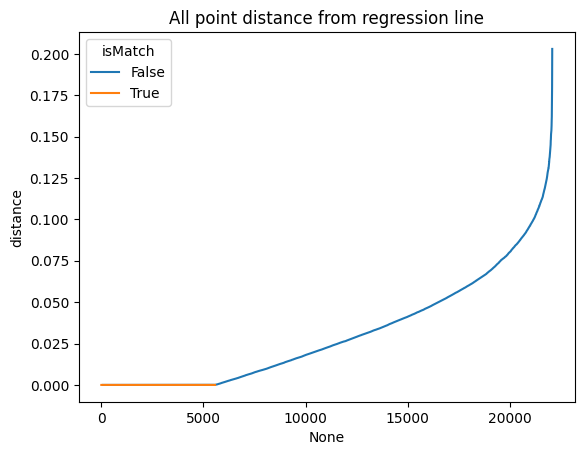

In [ ]:
import math
df = pd.DataFrame(distance_data, columns=['distance', 'isMatch', 'level'])
sns.lineplot(data=df, x=df.index, y='distance', hue='isMatch').set_title("All point distance from regression line")
# filter for those where isMatch is true
# df

In [ ]:
# get smallest distance where isMatch is False

min_distance = df.loc[df['isMatch'] == False, 'distance']
print(f"Min distance from line of fit for non-matches: {min_distance}")

Min distance from line of fit for non-matches: 80       0.000000
81       0.000000
82       0.000000
83       0.000000
84       0.000000
           ...   
22075    0.190015
22076    0.193166
22077    0.194851
22078    0.196686
22079    0.202993
Name: distance, Length: 16560, dtype: float64


# Naive Enumeration
Evaluation Function
Given an assignment [(word, group)], evaluate how close the assignment is.

idea: try all combinations and determine if the correct assignment does have the lowest value

In [7]:
from functools import reduce
import operator

def grouping_loss(word_embs:List[torch.Tensor]):
    """
    Given a list of 4 words in the same grouping, compute the loss as the MSE from their centroid
    """
    centroid = torch.mean(torch.stack(word_embs), dim=0)
    return sum(torch.norm(emb - centroid)**2 for emb in word_embs) / len(word_embs)

def connection_loss(assignment: List[Tuple[Any, int]]):
    """
    Given a list of assignments, compute the loss as the sum of the grouping losses
    """
    groups = defaultdict(list)
    for (emb, grp_id) in assignment:
        groups[grp_id].append(emb)
    words_emb = [group for group in groups.values()]
    return sum([grouping_loss(word_embs) for word_embs in words_emb])

test_assignment = []
for i in range(4):
    test_assignment.extend([(torch.tensor(m2.encode(word)), i) for word in sample_day.connections[i].words])

print(connection_loss(test_assignment))

tensor(2.0531)


In [71]:
def grouping_loss(word_embs: np.ndarray, *args):
    # Given a list of 4 words in the same grouping, compute the loss as the MSE from their centroid
    centroid = np.mean(word_embs, axis=0)
    # (word_embs - centroid)
    return np.average(np.linalg.norm(word_embs - centroid, axis=1)**2)

embs = m2.encode(sample_words[:4])
centroid = np.mean(embs, axis=0)
print(centroid.shape)
print(embs.shape)
print(np.linalg.norm(embs - centroid, axis=1))
print(sum(np.linalg.norm(embs - centroid, axis=1) ** 2)/4)
print(grouping_loss(embs))

assignments = np.ndarray((4, 4, emb_dims))
for i in range(4):
    assignments[i] = m2.encode(sample_day.connections[i].words)
# print(assignments)

assignment_losses = np.average(np.array([grouping_loss(assignments[i]) for i in range(4)])**2)
print(assignment_losses)

def connection_loss(assignments: np.ndarray):
    """
    input: np.ndarray of shape (4, 4, emb_dims)
    output: float
    """
    emb_losses = np.array([grouping_loss(assignments[i]) for i in range(4)])
    return np.average(emb_losses**2)


(384,)
(4, 384)
[0.6872724 0.5921867 0.5115346 0.5461687]
0.3457490801811218
0.34574908
0.2728237978841277


In [49]:
import itertools
import more_itertools

def generate_all_assignments() -> Generator[List[int], None, None]:
    """
    yield all possible assignments of 16 words to 4 different categories 0-3,
    such that each category has exactly 4 words in it.

    Output: list of 16 integers, each in the range 0-3, as the word assignment

    This takes about 2 minutes to iterate through 63 063 000 options
    """
    for perm in more_itertools.distinct_permutations([0] * 4 + [1] * 4 + [2] * 4 + [3] * 4):
        yield list(perm)

all_assignments = list(generate_all_assignments())

In [79]:
from tqdm import tqdm
import multiprocessing

# Compute the loss for a random subset of the assignments, including the correct one
sample_pct = 0.05
random_idxs = np.random.choice(len(all_assignments), int(len(all_assignments) * sample_pct))
random_subset = [all_assignments[i] for i in random_idxs]
correct_assignment = [0] * 4 + [1] * 4 + [2] * 4 + [3] * 4
if correct_assignment not in random_subset:
    random_subset.append(correct_assignment)

sample_embs = [torch.tensor(m2.encode(word)) for word in sample_words]
losses = []
todays_words = get_words(connections_days[0])
todays_embs = get_embeddings(todays_words).numpy()

def assignment_to_embs(assignment: List[int]) -> np.ndarray:
    embs_list = [{}, {}, {}, {}]
    for i in range(4):
        embs_list[i] = np.array([todays_embs[j] for j in range(len(todays_embs)) if assignment[j] == i])
    # given an assignment, return the embeddings for each word (4,4,emb_dims)
    return np.array(embs_list)

def process_item(assignment_chunks: List[List[int]]):
    interim_losses = []
    for assignment in assignment_chunks:
        emb = assignment_to_embs(assignment)
        interim_losses.append(connection_loss(emb))
    return interim_losses

losses = []
for assignment in tqdm(random_subset):
    embs = assignment_to_embs(assignment)
    losses.append(connection_loss(embs))

print(len(losses))

100%|██████████| 3153151/3153151 [17:51<00:00, 2943.18it/s]

3153151


Number of assignments with lower loss than actual: 449


Text(0, 0.25782381057739256, ' Assignments with better fit: 449 or 0.01%')

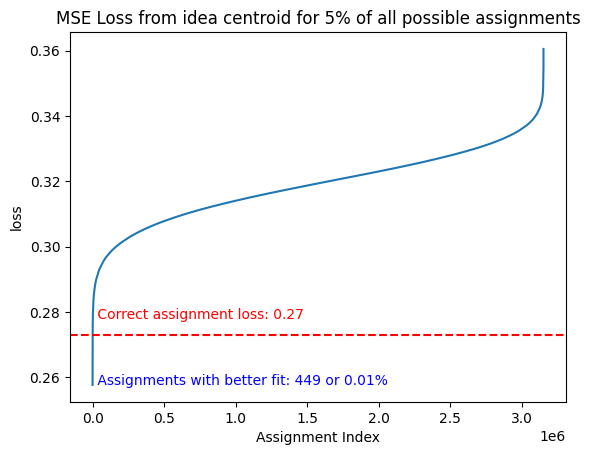

In [84]:
df = pd.DataFrame(losses, columns=['loss'])
df_sorted = df.sort_values(by='loss')
ax = sns.lineplot(data=df_sorted, x=df.index, y='loss')\
    .set_title("MSE Loss from idea centroid for 5% of all possible assignments")
# add a line for the loss of the actual assignment
test_assignment = assignment_to_embs(correct_assignment)
actual_loss = connection_loss(test_assignment)
plt.axhline(y=actual_loss, color='r', linestyle='--')
plt.text(0, actual_loss + 0.005, f" Correct assignment loss: {actual_loss:.2f}", color='r')
plt.xlabel("Assignment Index")

lower_than_actual_loss = df.loc[df['loss'] < actual_loss]
print(f"Number of assignments with lower loss than actual: {len(lower_than_actual_loss)}")

plt.text(0, actual_loss - 0.015, f" Assignments with better fit: {len(lower_than_actual_loss)} or {100 * (len(lower_than_actual_loss) / len(losses)):0.2f}%", color='b')

In [106]:
lowest_loss = df_sorted.iloc[0]['loss']
lowest_loss_assignment = random_subset[df.loc[df['loss'] == lowest_loss].index[0]]
grp = defaultdict(list)
for (wd, a) in zip(sample_words, lowest_loss_assignment):
    grp[a].append(word2level[wd] + wd)
print(f"Lowest loss: {lowest_loss} with assignment: {grp}")

Lowest loss: 1.9944243431091309 with assignment: defaultdict(<class 'list'>, {3: ['🟡DUCT', '🟡DRAIN', '🟡PIPE', '🟡SEWER'], 2: ['🟢CHEESE', '🟢CORN', '🔵EGG', '🔵KNUCKLES'], 0: ['🟢SAP', '🔵SMILE', '🔵WINDOW', '🟣LOOSE'], 1: ['🟢SCHMALTZ', '🟣CHUMP', '🟣CLIMATE', '🟣SEA']})


In [111]:
for vs in grp.values():
    print(' '.join(vs))

🟡DUCT 🟡DRAIN 🟡PIPE 🟡SEWER
🟢CHEESE 🟢CORN 🔵EGG 🔵KNUCKLES
🟢SAP 🔵SMILE 🔵WINDOW 🟣LOOSE
🟢SCHMALTZ 🟣CHUMP 🟣CLIMATE 🟣SEA


## Enumeration of groups of 4
What is the loss of any group of 4?
In what percentile is the correct grouping?
What is the distribution of colors for which the correct grouping is also the best fit?

In [104]:
# Group of 4 enumerations
from collections import Counter


words = sample_day.words()
groups_of_four_idxes = list(itertools.combinations(range(16), 4))
match_counter = Counter()
grouping_losses = []
sample_np_embs = [m2.encode(word) for word in words]

for grp in tqdm(groups_of_four_idxes):
    idxes = list(grp)
    is_match = is_idxes_match(idxes)
    match_counter[is_match] += 1

    tmp = [sample_np_embs[i] for i in idxes]
    embs = np.array(tmp)
    loss = grouping_loss(embs)
    grouping_losses.append((is_match, loss))


100%|██████████| 1820/1820 [00:00<00:00, 8128.30it/s]


Text(0, 0.5, 'Loss')

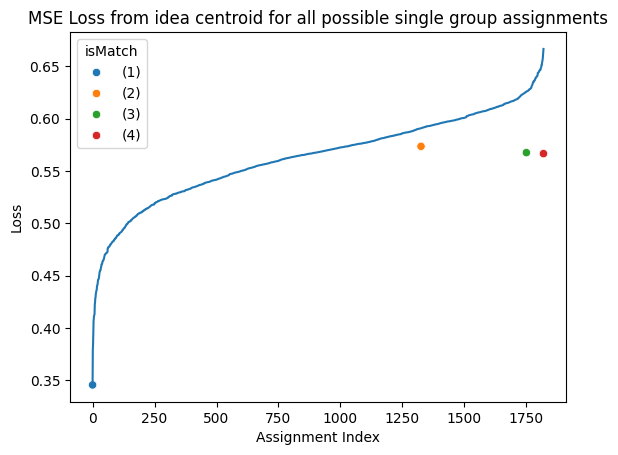

In [136]:
single_group_df = pd.DataFrame(grouping_losses, columns=['isMatch', 'loss'])
single_group_df_sorted = single_group_df.sort_values(by='loss')

ax = sns.lineplot(data=single_group_df_sorted, x=single_group_df.index, y='loss')\
    .set_title("MSE Loss from idea all possible single group assignments")

sgdf_correct = single_group_df.loc[single_group_df['isMatch']!= '(x)']

ax = sns.scatterplot(data=sgdf_correct, x=sgdf_correct.index, y='loss', hue=sgdf_correct['isMatch'])\
    .set_title("MSE Loss from idea centroid for all possible single group assignments")
plt.xlabel("Assignment Index")
plt.ylabel("Loss")


In [137]:
groups_of_four_idxes = list(itertools.combinations(range(16), 4))

all_single_grouping_losses = []
for cd in tqdm(connections_days):
    words = cd.words()

    match_counter = Counter()
    sample_np_embs = [m2.encode(word) for word in words]

    for grp in groups_of_four_idxes:
        idxes = list(grp)
        is_match = is_idxes_match(idxes)
        match_counter[is_match] += 1

        tmp = [sample_np_embs[i] for i in idxes]
        embs = np.array(tmp)
        loss = grouping_loss(embs)
        all_single_grouping_losses.append((is_match, loss, cd.iteration))

100%|██████████| 348/348 [03:11<00:00,  1.82it/s]


In [206]:
df = pd.DataFrame(all_single_grouping_losses, columns=['isMatch', 'loss', 'iteration'])
# Remove all rows where loss is 0
df = df.loc[df['loss'] > 0]
df = df.sort_values(by='loss')
# reindex
df = df.reset_index(drop=True)

# sns.lineplot(data=df, x=df.index, y='loss', hue='isMatch')

# Grouped by iteration, get the lowest non-'(x)' loss
newdf = df.loc[df['isMatch'] != '(x)'].groupby('iteration', as_index=False).first()
lower_than_correct = []
for row in df.itertuples():
    to_beat = newdf.loc[newdf['iteration'] == row[3]].iloc[0]
    if row[2] < to_beat['loss']:
        lower_than_correct.append(row)
# grouped = df.groupby('iteration')
# lowest_losses = []
# for name, group in grouped:
#     lowest_losses.append(group.loc[group['isMatch'] != '(x)'].iloc[0])
# newdf = pd.DataFrame(lowest_losses, columns=['isMatch', 'loss', 'iteration'])

# For each iteration, get the number of rows whose loss is less than the matching iteration's loss in newdf
# This will give us the number of times the correct grouping has the lowest loss
# lower_than_corect_df = df.loc[newdf['iteration'] == df['iteration']]

Pandas(Index=0, isMatch='(x)', loss=0.14601022005081177, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=1, isMatch='(x)', loss=0.1472475230693817, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=2, isMatch='(x)', loss=0.15303845703601837, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=3, isMatch='(x)', loss=0.15690360963344574, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=4, isMatch='(x)', loss=0.15866884589195251, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=5, isMatch='(x)', loss=0.15873393416404724, iteration=127)
iteration         127
isMatch           (1)
loss         0.161145
Name: 126, dtype: object
Pandas(Index=6, isMatch